# Why we do?

중고차 시장 데이터를 기반으로 자동차 가격을 예측해보려 합니다.

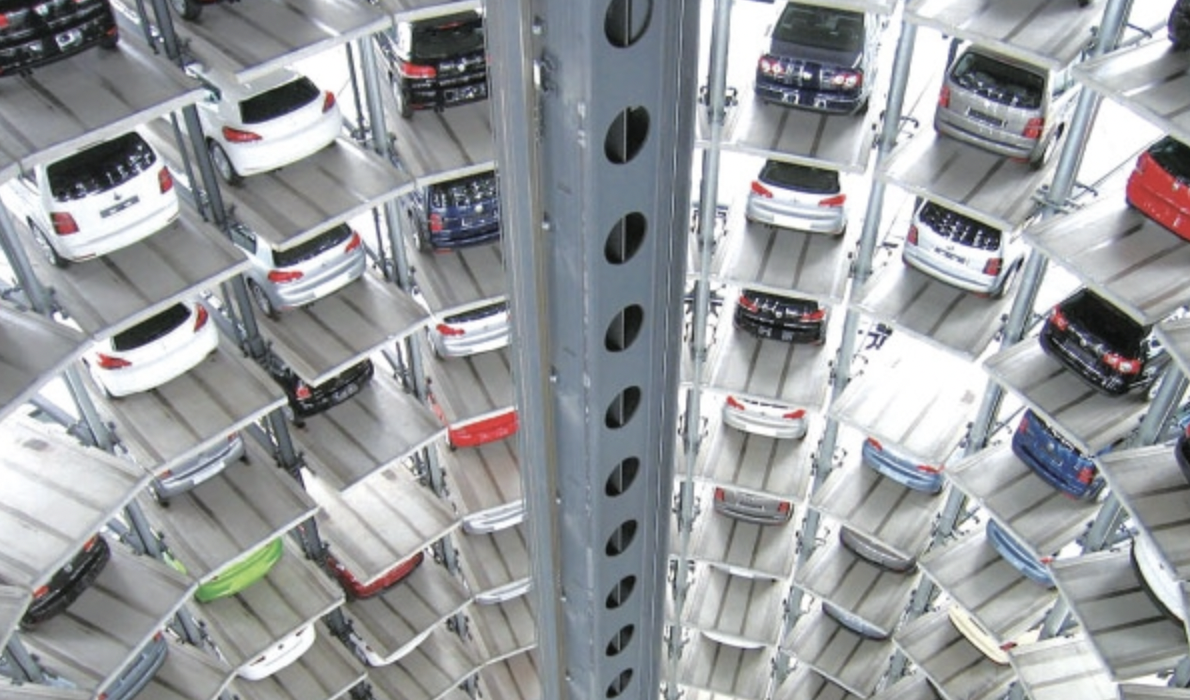

# Data

In [29]:
train = pd.read_csv("./drive-download-20220602T015750Z-001/train.csv")
test = pd.read_csv("./drive-download-20220602T015750Z-001/test.csv")
sample_submission = pd.read_csv("./drive-download-20220602T015750Z-001/sample_submission.csv")

train.drop(['id'],1,inplace=True)
test.drop(['id'],1,inplace=True)

In [3]:
train.head()

title  odometer location    isimported  \
0                   Toyota RAV 4     18277   Lagos   Foreign Used   
1            Toyota Land Cruiser        10    Lagos          New    
2  Land Rover Range Rover Evoque     83091    Lagos  Foreign Used   
3                   Lexus ES 350     91524    Lagos  Foreign Used   
4                   Toyota Venza     94177    Lagos  Foreign Used   

           engine transmission    fuel  paint  year    target  
0  4-cylinder(I4)    automatic  petrol    Red  2016  13665000  
1  4-cylinder(I4)    automatic  petrol  Black  2019  33015000  
2  6-cylinder(V6)    automatic  petrol    Red  2012   9915000  
3  4-cylinder(I4)    automatic  petrol   Gray  2007   3815000  
4  6-cylinder(V6)    automatic  petrol    Red  2010   7385000

* title : 제조사 모델명
* odometer : 주행 거리
* location : 판매처(나이지리아 도시)
* isimported : 현지 사용 여부
* engine : 엔진 종류
* transmission : 트랜스미션 종류
* fuel : 연료 종류
* paint : 페인트 색상
* year : 제조년도
* target : 자동차 가격

# Data Wrangling

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015 entries, 0 to 1014
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         1015 non-null   object
 1   odometer      1015 non-null   int64 
 2   location      1015 non-null   object
 3   isimported    1015 non-null   object
 4   engine        1015 non-null   object
 5   transmission  1015 non-null   object
 6   fuel          1015 non-null   object
 7   paint         1015 non-null   object
 8   year          1015 non-null   int64 
 9   target        1015 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 79.4+ KB


In [15]:
train.isnull().sum()

title           0
odometer        0
location        0
isimported      0
engine          0
transmission    0
fuel            0
paint           0
year            0
target          0
dtype: int64

In [7]:
train.shape, test.shape

((1015, 10), (436, 9))

In [8]:
train.describe()

odometer      year         target
count   1015.0000 1015.0000      1015.0000
mean  116842.1212 2008.3852   8243204.4502
std   105162.5458   35.5921  12395673.6040
min        0.0000 1217.0000    400000.0000
25%    55918.0000 2006.0000   2535000.0000
50%    94972.0000 2010.0000   4215000.0000
75%   153224.0000 2014.0000   8927500.0000
max   987322.0000 2020.0000 150015008.0000

**Obseravation**

* 주행거리(odometer)가 0인 데이터가 있습니다.
    * 사용하지 않은 차량인 듯 해요.
* 제조년도(year)가 1217년인 데이터가 있습니다.
* 자동차가격(target)에 매우 높은 값이 있습니다.

> 이상치를 처리해 줄 필요가 있습니다.

In [89]:
from IPython.core.display import HTML

def value_counts_all(df, columns):
    pd.set_option('display.max_rows',50)
    table_list=[]
    for col in columns:
        table_list.append(pd.DataFrame(df[col].value_counts()))
    return HTML(f"<table><tr> {''.join(['<td>'+table._repr_html_() + '</td>' for table in table_list])} </tr></table>")

value_counts_all(train,train.columns)

**Observation**

* location 컬럼에 중복된 클래스가 존재해요.
* Paint 컬럼 내 클래스명을 처리해줘야 해요.

# EDA

In [4]:
cat_cols  = train.select_dtypes(include='object').columns.tolist()
num_cols  = train.select_dtypes(exclude='object').columns.tolist()

<Figure size 1152x864 with 0 Axes>

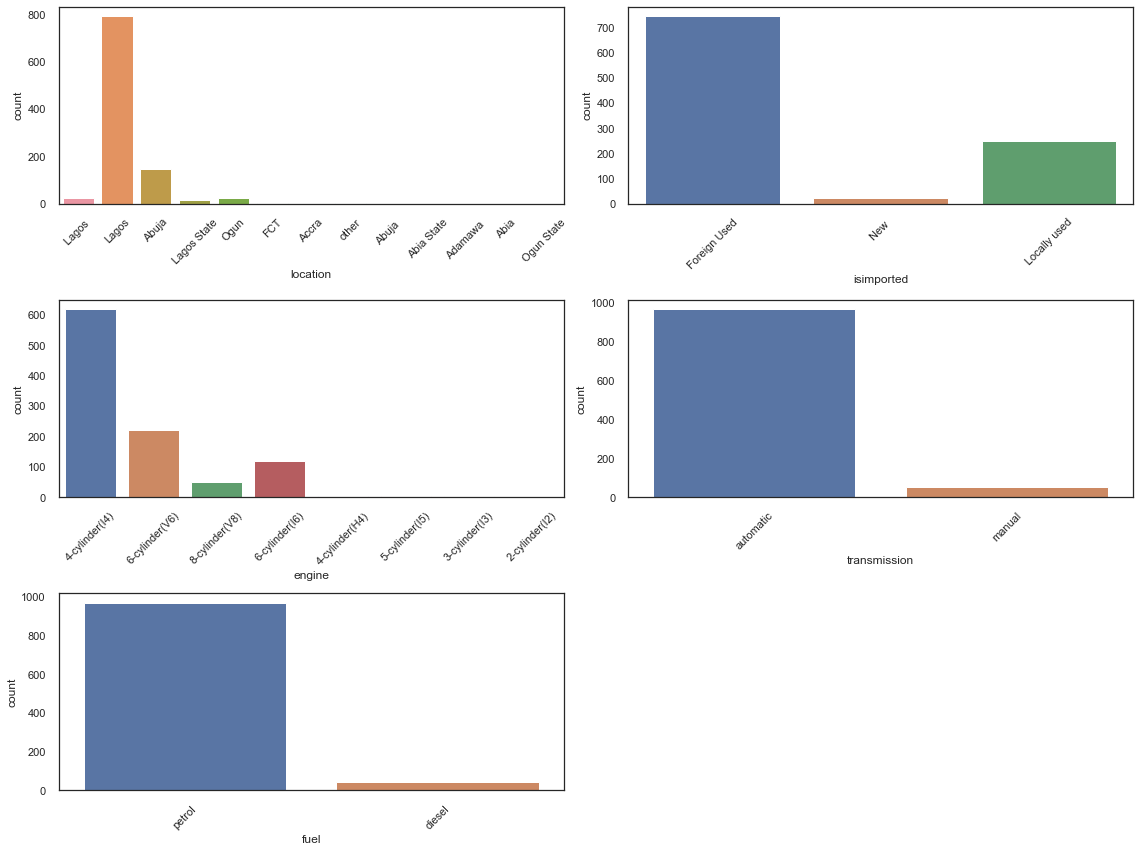

In [5]:
#categorical
sns.set(style='white')

i = 0
plt.figure(figsize=(16,12))
f,ax=plt.subplots(3,2,figsize=(16,12))
plt.delaxes(ax[2][1])
for col in ['location', 'isimported', 'engine', 'transmission', 'fuel']:
    i +=1
    plt.subplot(3,2,i)
    sns.countplot(x=train[col])
    plt.xticks(rotation=45)
    plt.tight_layout()

<Figure size 1080x216 with 0 Axes>

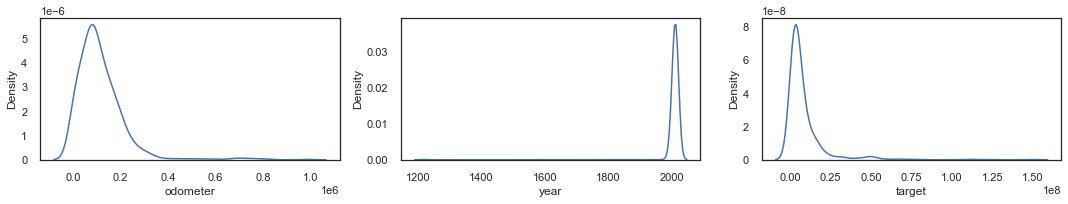

In [6]:
#categorical
sns.set(style='white')

i = 0
plt.figure(figsize=(15,3))
f,ax=plt.subplots(1,3,figsize=(15,3))
for col in num_cols:
    i +=1
    plt.subplot(1,3,i)
    sns.kdeplot(train[col])
    plt.tight_layout()

<AxesSubplot:>

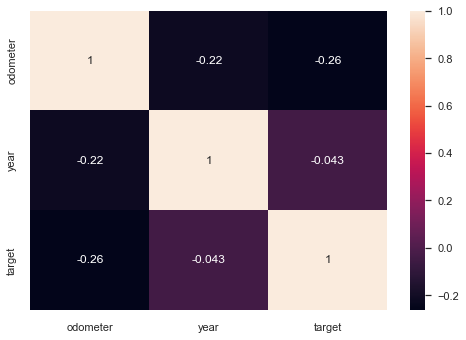

In [7]:
plt.figure()
sns.heatmap(train.corr(), annot=True)

**Observation** 

* 주행거리가 길다면 가격은 낮을 겁니다.

# Feature Engineering

In [30]:
train['manufacturer']=train['title'].str.split(' ',expand=True)[0]
test['manufacturer']=test['title'].str.split(' ',expand=True)[0]
train['manufacturer'].replace('Mercedes-Benz/52','Mercedes-Benz',inplace=True)

# Preprocessing

In [31]:
import re 

def clean_text(texts): 
    corpus = [] 
    for i in range(0, len(texts)): 
        review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"\n\]\[\>\<]', '',texts[i]) #@%*=()/+ 와 같은 문장부호 제거
        review = re.sub(r'\d+','',review)#숫자 제거
        review = review.lower() #소문자 변환
        review = re.sub(r'\s+', ' ', review) #extra space 제거
        review = re.sub(r'<[^>]+>','',review) #Html tags 제거
        review = re.sub(r'\s+', ' ', review) #spaces 제거
        review = re.sub(r"^\s+", '', review) #space from start 제거
        review = re.sub(r'\s+$', '', review) #space from the end 제거
        review = re.sub(r'_', ' ', review) #space from the end 제거
#         review = re.sub(r'l', '', review)
        corpus.append(review) 
        
    return corpus

train['paint'] = clean_text(train['paint']) #메소드 적용
test['paint'] = clean_text(test['paint'])

print('paint의 unique 카테고리 개수 : ', len(train['paint'].unique()))

train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'blue' if x.find('blue') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'red' if x.find('red') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'green' if x.find('green') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'white' if x.find('white') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'grey' if x.find('grey') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'grey' if x.find('gery') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'grey' if x.find('gray') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'ash' if x.find('ash') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'brown' if x.find('brown') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'silver' if x.find('silver') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'silver' if x.find('sliver') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'black' if x.find('black') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'gold' if x.find('gold') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'wine' if x.find('whine') >= 0 else x)

test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'blue' if x.find('blue') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'red' if x.find('red') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'green' if x.find('green') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'white' if x.find('white') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'grey' if x.find('grey') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'grey' if x.find('gery') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'grey' if x.find('gray') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'ash' if x.find('ash') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'brown' if x.find('brown') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'silver' if x.find('silver') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'silver' if x.find('sliver') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'black' if x.find('black') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'gold' if x.find('gold') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'wine' if x.find('whine') >= 0 else x)

#######################################################
numeric_fts = ['odometer', 'year']
outlier_ind = []
for i in numeric_fts:
    Q1 = np.percentile(train[i],25)
    Q3 = np.percentile(train[i],75)
    IQR = Q3-Q1
    outlier_list = train[(train[i] < Q1 - IQR * 1.5) | (train[i] > Q3 + IQR * 1.5)].index
    outlier_ind.extend(outlier_list)
    
train = train.drop(outlier_ind, axis = 0).reset_index(drop = True)    

#######################################################
train['location']=clean_text(train['location'])
test['location'] = clean_text(test['location'])

#######################################################
train.drop(train[(train['location'] =='other') & (train['target'] > 0.25 * 1e8)].index, inplace=True)
train.drop(train[(train['isimported'] =='Locally used') & (train['target'] > 1.25 * 1e8)].index,inplace=True)
train.drop(train[(train['engine'] =='8-cylinder(V8)') & (train['target'] > 0.3 * 1e8)].index,inplace=True)
train.drop(train[train['year'] < 1995].index,inplace=True)
train.drop(train[(train['year'] == 2014) & (train['target'] > 3 * 1e8)].index,inplace=True)

train.drop(train[(train['year'] =='2014') & (train['target'] > 4 * 1e8)].index,inplace=True)
train.drop(train[(train['year'] =='2015') & (train['target'] > 4 * 1e8)].index,inplace=True)
train.drop(train[(train['year'] =='2016') & (train['target'] > 4 * 1e8)].index,inplace=True)
train.drop(train[(train['year'] =='2017') & (train['target'] > 4 * 1e8)].index,inplace=True)
train.drop(train[(train['year'] =='2018') & (train['target'] > 4 * 1e8)].index,inplace=True)

#######################################################
#location
train['location'] = train['location'] = train['location'].apply(lambda x : 'lagos' if x.find('lagos') >= 0 else x)
train['location'] = train['location'] = train['location'].apply(lambda x : 'ogun' if x.find('ogun') >= 0 else x)
train['location'] = train['location'] = train['location'].apply(lambda x : 'abia' if x.find('abia') >= 0 else x)

test['location'] = test['location'] = test['location'].apply(lambda x : 'lagos' if x.find('lagos') >= 0 else x)
test['location'] = test['location'] = test['location'].apply(lambda x : 'ogun' if x.find('ogun') >= 0 else x)
test['location'] = test['location'] = test['location'].apply(lambda x : 'abia' if x.find('abia') >= 0 else x)


paint의 unique 카테고리 개수 :  51


## 이상치

In [24]:
numeric_fts = ['odometer', 'year']
outlier_ind = []
for i in numeric_fts:
    Q1 = np.percentile(train[i],25)
    Q3 = np.percentile(train[i],75)
    IQR = Q3-Q1
    outlier_list = train[(train[i] < Q1 - IQR * 1.5) | (train[i] > Q3 + IQR * 1.5)].index
    outlier_ind.extend(outlier_list)
    
train = train.drop(outlier_ind, axis = 0).reset_index(drop = True)    

<Figure size 1152x864 with 0 Axes>

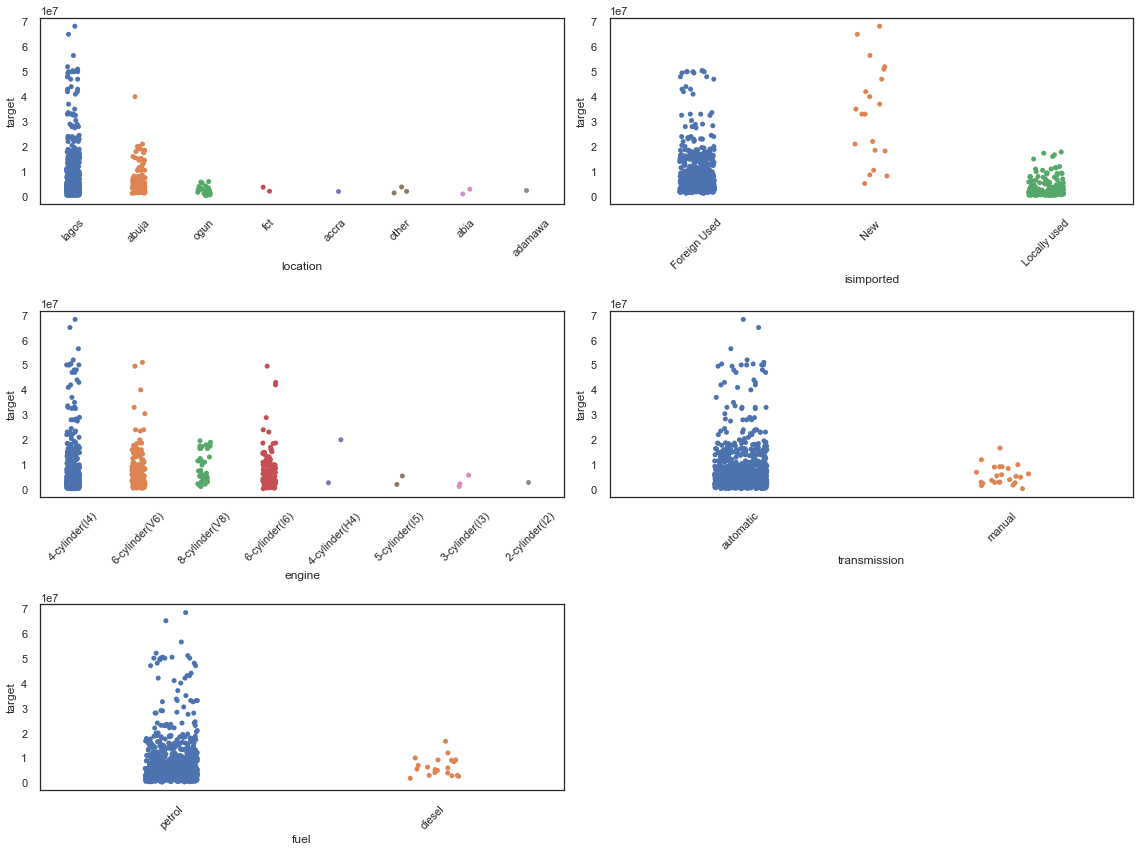

In [25]:
#categorical
sns.set(style='white')

i = 0
plt.figure(figsize=(16,12))
f,ax=plt.subplots(3,2,figsize=(16,12))
plt.delaxes(ax[2][1])
for col in ['location', 'isimported', 'engine', 'transmission', 'fuel']:
    i +=1
    plt.subplot(3,2,i)
    sns.stripplot(x=col, y ='target', data=train)
    plt.xticks(rotation=45)
    plt.tight_layout()

**Obseravation**

* location에 other클래스의 이상치를 제거합니다.
* isimported에 Locally used클래스의 이상치를 제거합니다.
* engine에 8-cylinder(V8)클래스의 이상치를 제거합니다.

In [26]:
train.drop(train[(train['location'] =='other') & (train['target'] > 0.25 * 1e8)].index, inplace=True)
train.drop(train[(train['isimported'] =='Locally used') & (train['target'] > 1.25 * 1e8)].index,inplace=True)
train.drop(train[(train['engine'] =='8-cylinder(V8)') & (train['target'] > 0.3 * 1e8)].index,inplace=True)

---

자연어 처리 과정이 있다면, 차집합을 사용해서 빠뜨린것은 없는지 확인하는 과정이 필요합니다.

In [32]:
set(test['paint']) - set(train['paint'])

{'blac', 'golf', 'indigo ink pearl'}

**Observation**

* blac -> black, golf -> gold로 수정합시다.

In [33]:
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'gold' if x.find('golf') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'black' if x.find('blac') >= 0 else x)

In [34]:
set(test['location']) - set(train['location'])

{'mushin'}

**Obseravation**

* mushin은 lagos 지역의 지방정부지역입니다. mushin을 lagos로 바꾸어줍시다.

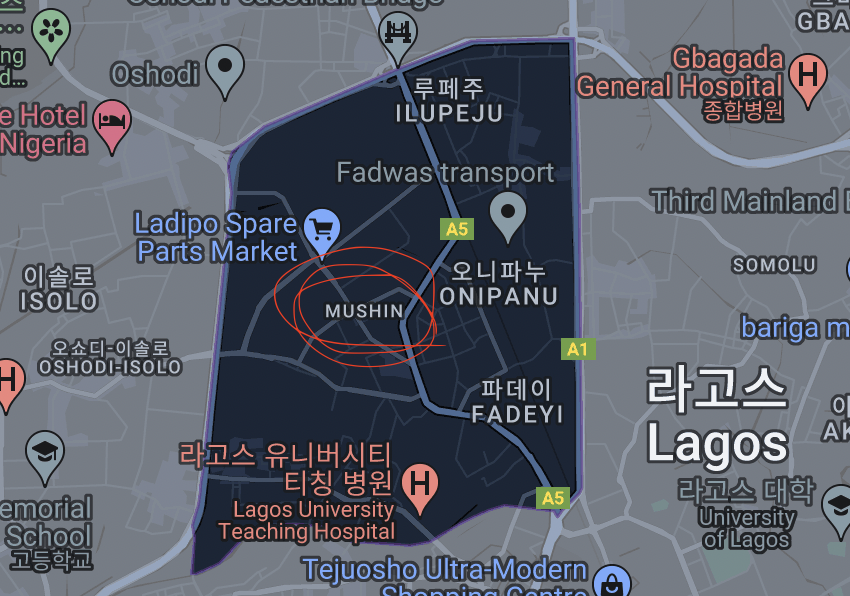

In [35]:
test['location'] = test['location'] = test['location'].apply(lambda x : 'lagos' if x.find('mushin') >= 0 else x)

---

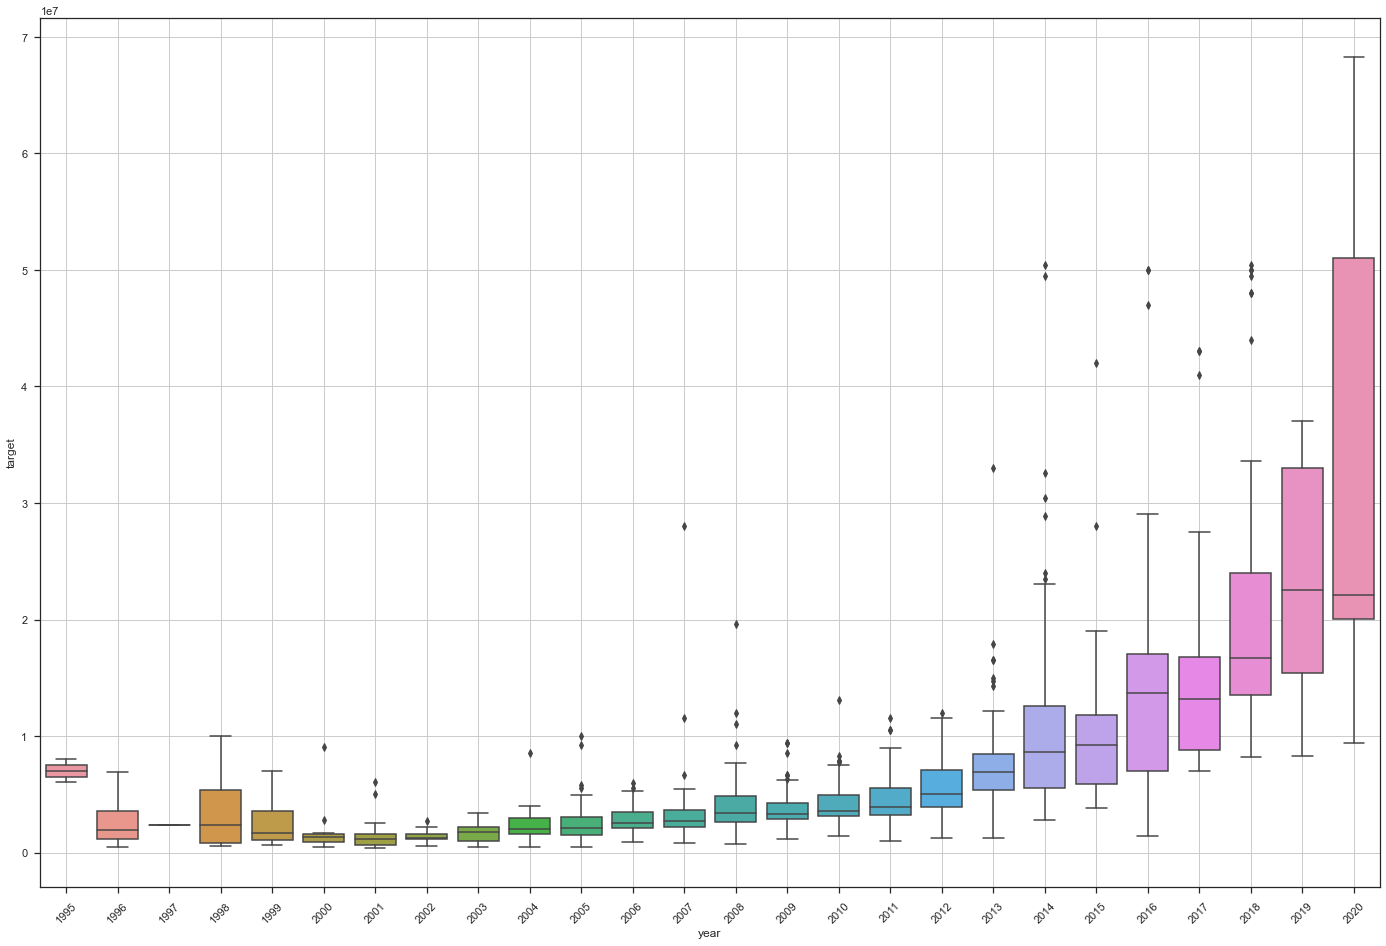

In [37]:
plt.figure(figsize=(24,16))
sns.set(style='ticks')
sns.boxplot(x='year', y='target',data=train)
plt.grid()
plt.xticks(rotation=45);

**Obseravation**

* 모델 적합을 위해 95년 이하의 데이터를 지우겠습니다. 
    * 그러나 95년도 클래스를 지웠더니 점수가 하락하였기에 94년도만 지우겠습니다.

In [39]:
train.drop(train[train['year'] < 1995].index,inplace=True)

# Modeling

In [40]:
def make_label_map(dataframe):
    label_maps = {}
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            label_map = {'unknown':0}
            for i, key in enumerate(dataframe[col].unique()):
                label_map[key] = i+1  #새로 등장하는 유니크 값들에 대해 1부터 1씩 증가시켜 키값을 부여해줍니다.
            label_maps[col] = label_map
    print(label_maps)
    return label_maps

# 각 범주형 변수에 인코딩 값을 부여하는 함수
def label_encoder(dataframe, label_map):
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            dataframe[col] = dataframe[col].map(label_map[col])
            dataframe[col] = dataframe[col].fillna(label_map[col]['unknown']) #혹시 모를 결측값은 unknown의 값(0)으로 채워줍니다.
    return dataframe

le = make_label_map(train)
train = label_encoder(train, le)
train.head()

{'title': {'unknown': 0, 'Toyota RAV 4': 1, 'Toyota Land Cruiser': 2, 'Land Rover Range Rover Evoque': 3, 'Lexus ES 350': 4, 'Toyota Venza': 5, 'Toyota Corolla': 6, 'Land Rover Range Rover Sport': 7, 'Pontiac Vibe': 8, 'Toyota Tacoma': 9, 'Lexus RX 350': 10, 'Ford Escape': 11, 'Honda Civic': 12, 'Volvo XC90': 13, 'BMW 750': 14, 'Infiniti JX': 15, 'Honda Accord': 16, 'Mercedes-Benz ML 350': 17, 'Toyota Camry': 18, 'Hyundai Azera': 19, 'Lexus GX 460': 20, 'BMW 325': 21, 'Toyota Sienna': 22, 'Honda Fit': 23, 'Honda CR-V': 24, 'Hyundai Tucson': 25, 'Jaguar XJ8': 26, 'BMW X6': 27, 'Mercedes-Benz C 300': 28, 'Mitsubishi Galant': 29, 'Mercedes-Benz GL 450': 30, 'Lexus RX 300': 31, 'Toyota Highlander': 32, 'Mitsubishi CANTER PICK UP': 33, 'Nissan Titan': 34, 'Lexus IS 250': 35, 'Mercedes-Benz 200': 36, 'Toyota Sequoia': 37, 'Ford Explorer': 38, 'Hyundai ix35': 39, 'Lexus CT 200h': 40, 'Lexus LX 570': 41, 'Toyota Avensis': 42, 'Toyota 4-Runner': 43, 'Mercedes-Benz GLE 350': 44, 'Mercedes-Benz E

title  odometer  location  isimported  engine  transmission  fuel  paint  \
0      1     18277         1           1       1             1     1      1   
1      2        10         1           2       1             1     1      2   
2      3     83091         1           1       2             1     1      1   
3      4     91524         1           1       1             1     1      3   
4      5     94177         1           1       2             1     1      1   

   year    target  manufacturer  
0  2016  13665000             1  
1  2019  33015000             1  
2  2012   9915000             2  
3  2007   3815000             3  
4  2010   7385000             1

## CATBOOST

In [41]:
X = train.drop(['target'], axis = 1) #training 데이터에서 피쳐 추출
y = train.target #training 데이터에서 중고차 가격 추출

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3, random_state=42)

from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

model = CatBoostRegressor(random_state=42,silent=True) # 모델 정의
model.fit(X_train,y_train) # 학습

def nmae(true, pred):

    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    
    return score

mae_score= -1*(cross_val_score(estimator=model,X=X_train,y=y_train,cv=10,
               scoring='neg_mean_absolute_error'))
score = mae_score / np.mean(np.abs(y_train))

print(f'mean score : {score.mean()}, (+/-) {score.std()}')

mean score : 0.23787863796637562, (+/-) 0.02599560787697966


In [42]:
from pycaret.regression import *

setup(data=train, target='target',fold_shuffle=True, session_id=123,silent=True)

AttributeError: 'Simple_Imputer' object has no attribute 'fill_value_categorical'

In [43]:
add_metric('nmae','NMAE',nmae,greater_is_better=False)

Name                                                       NMAE
Display Name                                               NMAE
Score Function                <function nmae at 0x7fa11997e550>
Scorer               make_scorer(nmae, greater_is_better=False)
Target                                                     pred
Args                                                         {}
Greater is Better                                         False
Custom                                                     True
Name: nmae, dtype: object

In [44]:
blend_model = compare_models(n_select=4, sort='NMAE')

In [45]:
blended_model = blend_models(blend_model,choose_better=True)

In [46]:
final_model = finalize_model(blended_model)

In [47]:
test = label_encoder(test, le) #범주형 피쳐 라벨인코딩

In [48]:
predict_model(final_model, test)

title  odometer  location  isimported  engine  transmission  fuel  \
0    28.0000      1234         2           2  1.0000             1     1   
1    16.0000     29938         2           1  1.0000             1     1   
2     0.0000     87501         1           1  1.0000             1     1   
3    22.0000    180894         1           3  2.0000             1     1   
4    80.0000    104814         1           1  1.0000             1     1   
..       ...       ...       ...         ...     ...           ...   ...   
431  85.0000     78175         1           1  2.0000             1     1   
432  61.0000    129223         1           1  2.0000             1     1   
433  17.0000    100943         1           1  1.0000             1     1   
434 126.0000     81463         1           1  1.0000             1     1   
435  22.0000       646         1           1  2.0000             1     1   

     paint  year  manufacturer         Label  
0   4.0000  2017       10.0000 13448640.2903  
1   4.0000  2013        6.0000  5361520.9424  
2   2.0000  2012       10.0000  6901260.2908  
3   3.0000  2001        1.0000   868671.1337  
4   4.0000  2000        1.0000  2618062.2639  
..     ...   ...           ...           ...  
431 5.0000  2014       10.0000 10301248.1989  
432 1.0000  2011        6.0000  4988384.5450  
433 2.0000  2013       10.0000  8553593.7057  
434 8.0000  2003        3.0000  3545295.9984  
435 6.0000  2006        1.0000  3619059.9754  

[436 rows x 11 columns]

In [50]:
prediction= predict_model(final_model, test)
sample_submission['target'] = prediction['Label']
sample_submission.to_csv("./drive-download-20220602T015750Z-001/submission.csv",index=False)

# Evaluate

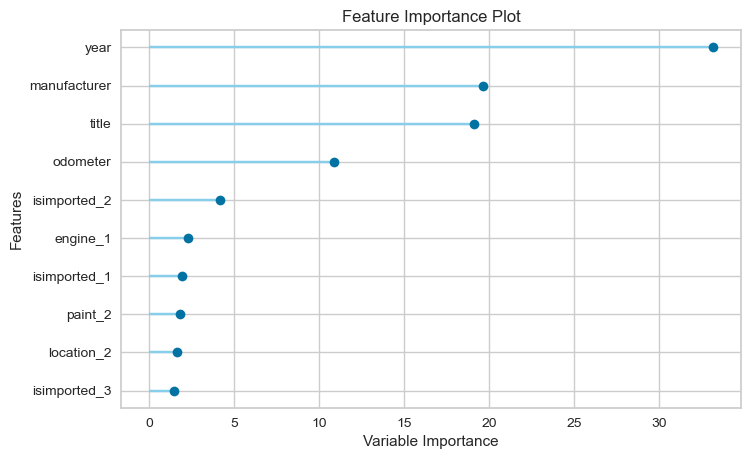

In [51]:
plot_model(final_model,plot='feature')

**Obseravation**

* year변수가 가장 중요했으며, title,manufacturer은 비슷한 중요도를 보이고 있습니다.
* paint와 odometer은 비교적 중요하지 않은 변수로 판단합니다.

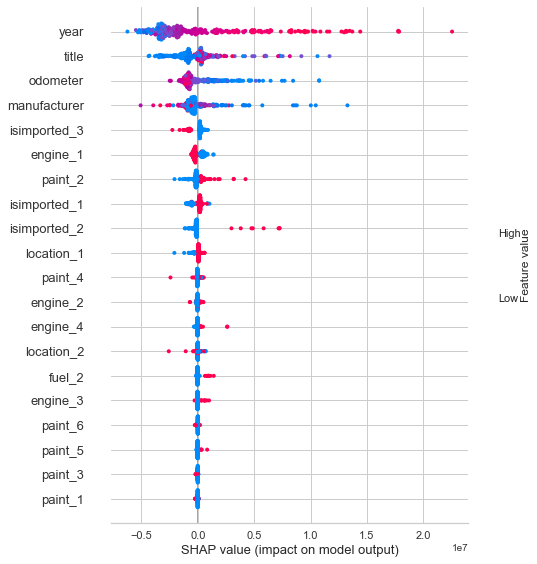

In [52]:
interpret_model(final_model,'summary')

**Obseravation**

* year값이 높으면 높을수록 높은 가격으로 책정합니다.
* odometer이 높은 경우, 즉 주행거리가 긴 경우에 낮은 가격으로 책정합니다.

In [290]:
interpret_model(final_model,'reason')

In [291]:
evaluate_model(final_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

# Question

<div>
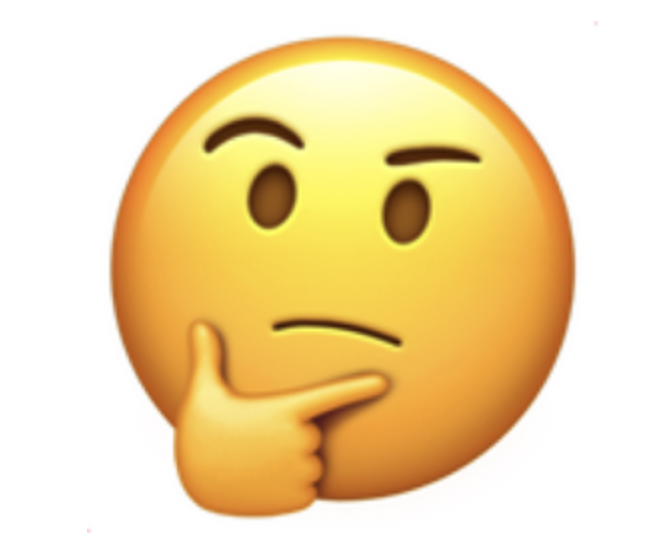
</div>

1. Test Set 내 paint 컬럼의 값들을 수정한다거나 location 컬럼에 공백제거, 소문자로 변경한다는 등의 전처리는 Data  Leakage일까요?  
 *  ```grey``` -> ```gray``` 
 * ```'Lagos '```-> ```Lagos```

# Ah-ha!

* numerical 변수에서 이상치를 제거했다면, 모델 적합을 위해 categorical 변수도 target과 비교하여 이상치를 제거한다.



* 자연어처리를 한 컬럼이 있다면, 차집합을 활용해서 빠뜨린건 없는지 확인하는 과정이 필요하다.
    * e.g. mushin